How to run a smoothed particles Hydrodynamics simulation
====================

We will run a hydrodynamical simulation using a smoothed-particles hydrodynamics code.

For reference you can read chapter 5 of Portegies Zwart & McMillan 2018 (2018araa.book.....P). 

For this experiment, we will evolve a high-mass star to the end of its lifetime using a Henyey stellar evolution code (this may take a while).
We subsequently convert the star to a hydrodynamical realization in particles and inject the supernova energy to the inner few SPH-particles. We further simulate the evolution of the gas-blob in time using a hydrodynamics code.

To reduce the runtime of the calculation, we do not evolve the star to the end of its evolution, but just for a short while. Of course, the exploding star, in that case, will still be that of a main-sequence star.

The script in this notebook is based on the work by [Rimoldi et al.](https://ui.adsabs.harvard.edu/abs/2016ComAC...3....2R/abstract).

With this tutorial you will learn
 * Run another AMUSE module to generate initial conditions for yet another code.
 * How to recover the crash of a code and pick up the result.
 * Store simulation data in the form of python pickle files, and recover from those.
 * Plot the result of a hydrodynamical simulation.
 * Make an animation of simulation results.
 * Run an AMUSE module as a parallel job.
 * Evolve a star to a certain evolutionary stage.
 
This tutorial will require the stellar evolution code MESA to evolve the star. A separate file with a pre-calculated stellar sturcture is available (super_giant_stellar_structure.pkl), but reading in this file still requires MESA to be installed.

In [4]:
%matplotlib inline
import os
import numpy
import numpy as np
from matplotlib import pyplot as plt
from amuse.units import units

After loading in the most essential modules, we will set up the stellar evolution. In case MESA is unavailable, the repository contains a copy of the resulting stellar structure file. Simply switch which line defining *pickle_file* is commented out. 

In [6]:
from amuse.ext.star_to_sph import (pickle_stellar_model, convert_stellar_model_to_SPH,)
from amuse.test.amusetest import get_path_to_results
#from amuse.community.mesa.interface import MESA
from amuse.datamodel import Particles

def setup_stellar_evolution_model():
    out_pickle_file = os.path.join(get_path_to_results(), 
                                   "super_giant_stellar_structure.pkl")

    stellar_evolution = MESA(redirection="none")
    stars = Particles(1)
    stars.mass = 15.0 | units.MSun
    stellar_evolution.particles.add_particles(stars)
    stellar_evolution.commit_particles()

    print(
        "Evolving a MESA star with mass:",
        stellar_evolution.particles[0].mass
    )
    try:
        while stellar_evolution.model_time<0.12|units.Myr:
            stellar_evolution.evolve_model()
            print("star:", stellar_evolution.particles[0].stellar_type, stellar_evolution.model_time.in_(units.Myr))
    except AmuseException as ex:
        print("Evolved star to", stellar_evolution.particles[0].age)
        print("Radius:", stellar_evolution.particles[0].radius)
    
    pickle_stellar_model(stellar_evolution.particles[0], out_pickle_file)
    stellar_evolution.stop()
    return out_pickle_file

#pickle_file = setup_stellar_evolution_model()
pickle_file = './super_giant_stellar_structure.pkl'
print("Star generated.")

Star generated.


We have now set up the stellar model in a Henyey-code compatible form. Now we have to convert that into a distribution of SPH particles. There is a function in AMUSE to do this. 

In [7]:
number_of_sph_particles = 100
print(pickle_file)
print("Creating initial conditions from a MESA stellar evolution model...")
model = convert_stellar_model_to_SPH(
        None,
        number_of_sph_particles,
        seed=12345,
        pickle_file=pickle_file,
        #        base_grid_options = dict(type = "glass", target_rms = 0.01),
        with_core_particle=True,
        target_core_mass = 1.4|units.MSun
    )
print("model=", model)
core, gas_without_core, core_radius = \
        model.core_particle, model.gas_particles, model.core_radius
print("Created", len(gas_without_core),
       "SPH particles and one 'core-particle':\n", core)
print("Setting gravitational smoothing to:", core_radius.in_(units.km))

./super_giant_stellar_structure.pkl
Creating initial conditions from a MESA stellar evolution model...
model= StellarModelInSPH(gas_particles=<amuse.datamodel.particles.Particles object at 0x7f6a51b14490>, core_particle=<amuse.datamodel.particles.Particle object at 0x7f6a51aa2380>, core_radius=quantity<5735590730.5 0.01 * m>)
Created 100 SPH particles and one 'core-particle':
 Particle(12872059461542805024, set=<140094613323488>
    , mass=1.41745536512 MSun
    , radius=5735590730.5 0.01 * m
    , vx=0.0 m / s
    , vy=0.0 m / s
    , vz=0.0 m / s
    , x=0.0 m
    , y=0.0 m
    , z=0.0 m)
Setting gravitational smoothing to: 57355.907305 km


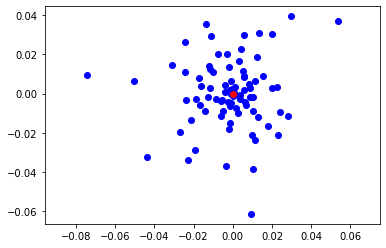

In [8]:
def plot_star(core, gas):
    plt.scatter(gas.x.value_in(units.au), gas.y.value_in(units.au), c='b')
    plt.scatter(core.x.value_in(units.au), core.y.value_in(units.au), c='r')
    plt.axis("equal")
    plt.show()

plot_star(core, gas_without_core)

Note that the mass of the core is not precisely what you put in. 
The reason is that mass has to be preserved in the simulation, and we remove a number of SPH particles to accomodate the mass of the core. It happens to be the case that the sum of the masses of these SPH particles slightly exceeds our intended core mass.

In [9]:
def inject_supernova_energy(gas_particles, 
                            explosion_energy=1.0e+51|units.erg,
                            exploding_region=10|units.RSun):
    inner = gas_particles.select(
        lambda pos: pos.length_squared() < exploding_region**2,
        ["position"])
    print(len(inner), "innermost particles selected.")
    print("Adding", explosion_energy / inner.total_mass(), "of supernova " \
        "(specific internal) energy to each of the n=", len(inner), "SPH particles.")
    inner.u += explosion_energy / inner.total_mass()
    
inject_supernova_energy(gas_without_core, exploding_region=1|units.RSun)

23 innermost particles selected.
Adding 1.62762713752e+20 1e-07 * m**2 * s**-2 of supernova (specific internal) energy to each of the n= 23 SPH particles.


Here we injected 10^51 erg in the inner-most SPH particles (those within 1 RSun of the stellar center). It turns out that we spread the supernova energy among the inner-most SPH particles. Spreading it over too few particles introduces interesting side effects, such as individual SPH particles being launched, as bullets, from the exploding star. Spreading the supernova energy over too many SPH particles, also has interesting consequences: the explosion would them drive the homologeous expansion of the entire star, rather than an explosion from the inside. 

In [10]:
from amuse.community.fi.interface import Fi
from amuse.lab import nbody_system
converter = nbody_system.nbody_to_si(10|units.MSun, core_radius)

hydro_code = Fi(converter)
hydro_code.parameters.epsilon_squared = core_radius**2
hydro_code.parameters.n_smooth_tol = 0.01
hydro_code.gas_particles.add_particles(gas_without_core)
hydro_code.dm_particles.add_particle(core)

We introduced and initialized the hydrodynamics solver, for which we adopted *Fi*. An alternative would be to use *Gadget2* or a grid-based hydro code.
Each hydro solver has its advantages and disadvantages. For SPH, the smoothing length and associated tolerance are important parameters to set. Another important parameter is the artivicial viscosity parameter *alpha*. You may want to experiment with those settings, probably breaking the code on the way.

In [11]:
from amuse.datamodel import Grid, new_regular_grid

def hydro_plot(hydro_code, view_size, npixels):
    view = [-1, 1, -1, 1] * view_size
    shape = (npixels, npixels, 1)
    size = npixels**2
    axis_lengths = [0.0, 0.0, 0.0] | units.m
    axis_lengths[0] = view[1] - view[0]
    axis_lengths[1] = view[3] - view[2]
    grid = new_regular_grid(shape, axis_lengths)
    grid.x += view[0]
    grid.y += view[2]
    speed = grid.z.reshape(size) * (0 | 1/units.s)
    rho, rhovx, rhovy, rhovz, rhoe = hydro_code.get_hydro_state_at_point(
            grid.x.reshape(size),
            grid.y.reshape(size),
            grid.z.reshape(size), speed, speed, speed)

    # we have to make some cuts in the parameter space.
    min_v = 800.0 | units.km / units.s
    max_v = 3000.0 | units.km / units.s
    min_rho = 3.0e-9 | units.g / units.cm**3
    max_rho = 1.0e-5 | units.g / units.cm**3
    min_E = 1.0e11 | units.J / units.kg
    max_E = 1.0e13 | units.J / units.kg

    v_sqr = (rhovx**2 + rhovy**2 + rhovz**2) / rho**2
    E = rhoe / rho
    log_v = numpy.log((v_sqr / min_v**2)) / numpy.log((max_v**2 / min_v**2))
    log_rho = numpy.log((rho / min_rho)) / numpy.log((max_rho / min_rho))
    log_E = numpy.log((E / min_E)) / numpy.log((max_E / min_E))

    red = numpy.minimum(numpy.ones_like(rho.number), numpy.maximum(
        numpy.zeros_like(rho.number), log_rho)).reshape(shape)
    green = numpy.minimum(numpy.ones_like(rho.number), numpy.maximum(
        numpy.zeros_like(rho.number), log_v)).reshape(shape)
    blue = numpy.minimum(numpy.ones_like(rho.number), numpy.maximum(
        numpy.zeros_like(rho.number), log_E)).reshape(shape)
    alpha = numpy.minimum(
            numpy.ones_like(log_v),
            numpy.maximum(
                numpy.zeros_like(log_v),
                numpy.log((rho / (10*min_rho)))
                )
            ).reshape(shape)

    rgba = numpy.concatenate((red, green, blue, alpha), axis=2)
    
    
    plt.figure(figsize=(npixels/100.0, npixels/100.0), dpi=100)
    plt.imshow(rgba)

We are done setting up the experiment, and can start to run production.
In this case, we decided to run in small parts of 10 seconds, 1 minute, 1 hour and 1 day, to see what happens to the exploding star.

Done running to time= 11.922198893 s
done plotting


/home/tunde/.local/lib/python3.8/site-packages/amuse/units/quantities.py:141: RuntimeWarning: invalid value encountered in true_divide
  return new_quantity_nonone(operator.__truediv__(self.number,other.number), (self.unit / other.unit).to_simple_form())
/tmp/ipykernel_65900/1527271642.py:30: RuntimeWarning: divide by zero encountered in log
  log_rho = numpy.log((rho / min_rho)) / numpy.log((max_rho / min_rho))
/tmp/ipykernel_65900/1527271642.py:43: RuntimeWarning: divide by zero encountered in log
  numpy.log((rho / (10*min_rho)))


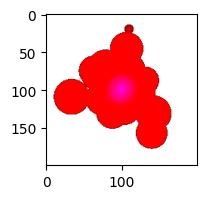

In [12]:
hydro_code.evolve_model(10.0|units.s)
print("Done running to time=", hydro_code.model_time.in_(units.s))
view_size = 20 | units.RSun 
npixels = 200
hydro_plot(hydro_code, view_size, npixels)
print("done plotting")

Done running to time= 0.993516574413 min


/tmp/ipykernel_65900/1527271642.py:30: RuntimeWarning: divide by zero encountered in log
  log_rho = numpy.log((rho / min_rho)) / numpy.log((max_rho / min_rho))
/tmp/ipykernel_65900/1527271642.py:43: RuntimeWarning: divide by zero encountered in log
  numpy.log((rho / (10*min_rho)))


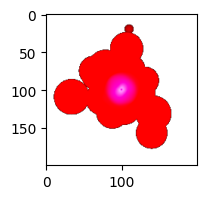

In [13]:
hydro_code.evolve_model(1.0|units.minute)
print("Done running to time=", hydro_code.model_time.in_(units.minute))
hydro_plot(hydro_code, view_size, npixels)

In [14]:
print("v-core=", hydro_code.dm_particles.velocity.length().in_(units.kms))
print("d-core=", hydro_code.dm_particles.position.length().in_(units.RSun))

v-core= 13.0176073422 kms
d-core= 0.000867988935311 RSun


Done running: 1.00014001824 hr


/tmp/ipykernel_65900/1527271642.py:30: RuntimeWarning: divide by zero encountered in log
  log_rho = numpy.log((rho / min_rho)) / numpy.log((max_rho / min_rho))
/tmp/ipykernel_65900/1527271642.py:43: RuntimeWarning: divide by zero encountered in log
  numpy.log((rho / (10*min_rho)))


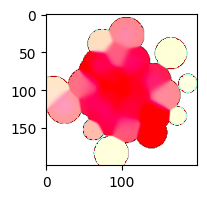

In [15]:
hydro_code.evolve_model(1.0 | units.hour)
print("Done running:", hydro_code.model_time.in_(units.hour))
hydro_plot(hydro_code, view_size, npixels)

Done running, until: 2.00028003648 hr
Done running, until: 3.00042005473 hr


/tmp/ipykernel_65900/1527271642.py:30: RuntimeWarning: divide by zero encountered in log
  log_rho = numpy.log((rho / min_rho)) / numpy.log((max_rho / min_rho))
/tmp/ipykernel_65900/1527271642.py:43: RuntimeWarning: divide by zero encountered in log
  numpy.log((rho / (10*min_rho)))


Done running, until: 4.00056007297 hr
Done running, until: 5.00070009121 hr
Done running, until: 6.00084010945 hr
Done running, until: 7.00098012769 hr
Done running, until: 8.00112014594 hr


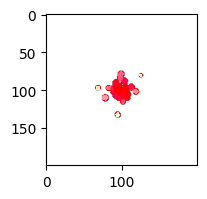

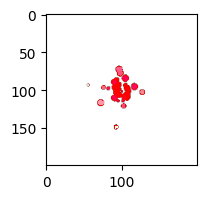

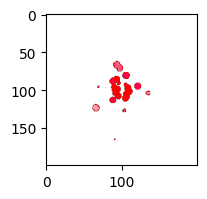

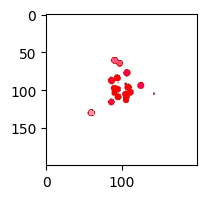

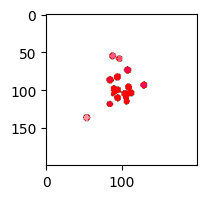

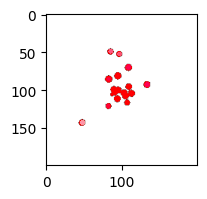

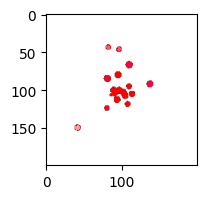

In [16]:
view_size = 100 | units.RSun
while hydro_code.model_time<0.3|units.day:
    hydro_code.evolve_model(hydro_code.model_time+(1|units.hour))
    print("Done running, until:", hydro_code.model_time.in_(units.hour))
    hydro_plot(hydro_code, view_size, npixels)

By this time the entire star has probably disappeard.

In [17]:
print("core=", hydro_code.dm_particles.velocity.length().in_(units.kms))
print("core=", hydro_code.dm_particles.position.length().in_(units.RSun))

core= 98.5625889241 kms
core= 2.04365874832 RSun


In [18]:
hydro_code.stop()

You have performed a hydrodynamical simulation of an exploding star. This was realized by first evolving the star to an advanced state using a 1D stellar evolution (a so-called Henyey) code. This one-dimensional structure was subsequently converted to a 3-dimensional hydrodynamical distribution of particles, representing the core and the gaseous envelope.

We injected a supernova-amount of energy into the hydrodynamical blob, heating the inner most particles to extreemely high temperatures and let the hydrodynamical code calculate the response.
The result was calculated 10 seconds, 1 minute, 1 hour and 1 day after the explosion.


Assignments and questions:
---------------

Note: the script is configured for running with 100 SPH particles, which is too small to study the morphology of the final simulation results, 1 day after the initiation of the supernova. Try running with 1000 or 10000 SPH particles, of better even would be to run with 30000 particles. However, the runs will become rather expensive. Most questions you can answer with ony 1000 SPH particles.

### Assignment 1:
You can increase the performance of the code by allowing it to run on multiple cores.
increase the number of SPH particles from 100 to 1000, and run the code again on as many cores as your computer can muster. Does this indeed increase the code performance? And by how much?

Note that Fi has to be set up differently to use multiple cores. Instead of passing *number_of_workers=4* (for 4 workers) when initializing Fi, you have to pass the *mode='openmp'* keyword and set the *OMP_NUM_THREADS* environment variable to the number of workers (using e.g. export or setenv depending on your shell), which has to be done in the same terminal session as your notebook runs in (so you may have to restart). You can check if this worked by also passing Fi the *redirection='none'* keyword. In the terminal running the notebook you should then see *omp threads* and some number.

We evolved the star for only 0.12 Myr, which, of course, is too short for a 15 MSun star to even leave the main sequence. A better time scale for such a star is 12Myr.

### Assignment 2:
Evolve the 15MSun star to 12Myr, and use this stellar structure as input for the hydrodynamics solver.

Rather than guessing the main-sequence lifetime of the 15MSun star, one could run the stellar evolution code until it crashes. In that case, the stellar evolution code will automatically terminate while saving the last consistent stellar evolution model. This model can subsequently be used to start the hydrodynamical simulation. This may be preferrable, except that running the stellar evolution code to this point is expensive.

In particular the last few steps are time consuming and do not really change that part of the star in which we are most interested (the density gradient between the core-region and the envelope. This part is already converged to its final density profile once the star ascends the second asymptotic giant branch. You can shorten runtime considerably by allowing the star to evolve to that point in its evolution.

### Question 1:
Where is the stellar model saved, once produced?
What is the age and radius of the star at the moment it starts to ascend the first giant branch?

### Assignment 3:
Rather than evolving the star until the desired moment, we can reuse the same star over and over again without rerunning, at least so long as we do not change the mass of the star. 
You can use the internal amuse routine *get_path_to_results* to store the picke file in your local amuse repository in $AMUSE_DIR/test_results.

Add the necessary lines to the *setup_stellar_evolution_model* script in which the star is evolved to picke the result of the stellar evolution calculation if a new calculation is performed. But first check if the desired pickled star already exist, in which case you should not redo the simulation. 

In addition, change the script in which the star is evolved to let it run until the star has reached the asymptotic giant branch.

### Question 2:
In the routine *inject_supernova_energy* we use a *lambda* function. Explain what this function does.

### Question 3:
In the three images, after running for 10 seconds, 1 minute and 1 hour, the star only seem to change color in the images. Explain why this is.

### Assigment 4:
In the routine *plot_hydro* we assign various parameters to the colors red, green and blue, and to the transparancy alpha. Explain what these parameters mean, and how this translates to the various colors you observed in the plotted pictures.

### Assignment 5:
Rerun the calculation but plot the kinetic energy, the potential energy and the total energy of the gas as a function of time from the start of the supernova to 2 days after the supernova. Describe the curves and explain what is happening.

### Questions 4:
Check the velocity of the neutron star at the end of the simulation.
It is not zero, as it was initially. Why is this the case?

### Assignment 6:
Usually neutron stars are believed to recieve rather high "natal" kicks upon birth. We still do not really understand why. In our simulations, we can introduce such a kick velocity by hand. A reasonable kick for a neutron star could be about 250km/s.
Impose such a high velocity kick to the newly born neutron star at the moment of the actual explosion and rerung the simulation.

### Question 5:
What effect that the high natal velocity kick of the neutron star has on the morphology and energy budget of the hydrodynamical outflow of the supernova shell?

### Assignment 5:
Add the appropriate lines to the plotting routine to write the images to files.
Rerun the code, and make an animation of the exploding star.